# Spaceship Titanic - Feature Engineering и PCA

Задача: создать признаки для датасета Spaceship Titanic, применить PCA и сравнить качество моделей

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Загрузка данных

In [23]:
train_df = pd.read_csv('../data/spaceship-titanic/train.csv')
test_df = pd.read_csv('../data/spaceship-titanic/test.csv')

print(f"Train: {train_df.shape}")
print(f"Test: {test_df.shape}")
print(f"\nБаланс классов:\n{train_df['Transported'].value_counts(normalize=True)}")

Train: (8693, 14)
Test: (4277, 13)

Баланс классов:
Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


In [24]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [25]:
# Проверка пропусков
missing = train_df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
print("Пропуски:")
print(missing)

Пропуски:
CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64


## Feature Engineering

Создаем новые признаки из существующих данных

In [26]:
def create_features(df):
    df = df.copy()
    
    # Разбиваем PassengerId на группу и номер
    df[['GroupId', 'PersonInGroup']] = df['PassengerId'].str.split('_', expand=True)
    df['GroupId'] = df['GroupId'].astype(int)
    df['PersonInGroup'] = df['PersonInGroup'].astype(int)
    
    # Размер группы
    group_sizes = df.groupby('GroupId').size()
    df['GroupSize'] = df['GroupId'].map(group_sizes)
    df['IsSolo'] = (df['GroupSize'] == 1).astype(int)
    
    # Разбиваем Cabin
    df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')
    
    # Агрегированные траты
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_cols].sum(axis=1)
    df['NumServices'] = (df[spending_cols] > 0).sum(axis=1)
    df['AvgSpending'] = df['TotalSpending'] / df['NumServices'].replace(0, np.nan)
    df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
    
    # Фамилии
    df[['FirstName', 'LastName']] = df['Name'].str.split(' ', n=1, expand=True)
    lastname_counts = df['LastName'].value_counts()
    df['FamilySize'] = df['LastName'].map(lastname_counts)
    
    # Возрастные группы
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 30, 50, 100], 
                             labels=['Child', 'Teen', 'Young', 'Adult', 'Senior'])
    
    return df

In [27]:
train_df = create_features(train_df)
test_df = create_features(test_df)

print(f"Создано признаков, итого колонок: {train_df.shape[1]}")

Создано признаков, итого колонок: 29


## Preprocessing

In [28]:
def preprocess_data(df):
    df = df.copy()
    
    # Заполнение пропусков
    numeric_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                    'CabinNum', 'TotalSpending', 'NumServices', 'AvgSpending',
                    'GroupId', 'PersonInGroup', 'GroupSize', 'IsSolo', 'FamilySize']
    for col in numeric_cols:
        if col in df.columns:
            df[col].fillna(df[col].median(), inplace=True)
    
    categorical_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'AgeGroup']
    for col in categorical_cols:
        if col in df.columns:
            df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown', inplace=True)
    
    # Удаляем ненужные колонки
    cols_to_drop = ['PassengerId', 'Name', 'Cabin', 'FirstName', 'LastName']
    df = df.drop(columns=[col for col in cols_to_drop if col in df.columns])
    
    # Кодирование
    bool_cols = ['CryoSleep', 'VIP']
    for col in bool_cols:
        if col in df.columns:
            df[col] = df[col].astype(int)
    
    categorical_for_encoding = ['HomePlanet', 'Destination', 'Deck', 'Side', 'AgeGroup']
    df = pd.get_dummies(df, columns=categorical_for_encoding, drop_first=True)
    
    return df

In [29]:
train_processed = preprocess_data(train_df)
test_processed = preprocess_data(test_df)

X = train_processed.drop('Transported', axis=1)
y = train_processed['Transported'].astype(int)

# Выравниваем колонки для test
missing_cols = set(X.columns) - set(test_processed.columns)
for col in missing_cols:
    test_processed[col] = 0
extra_cols = set(test_processed.columns) - set(X.columns)
test_processed = test_processed.drop(columns=extra_cols)
test_processed = test_processed[X.columns]

# Train/val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Признаков: {X.shape[1]}")
print(f"Train: {X_train.shape[0]}, Val: {X_val.shape[0]}")

Признаков: 34
Train: 6954, Val: 1739


In [30]:
train_processed.head()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,GroupId,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Side_S,AgeGroup_Teen,AgeGroup_Young,AgeGroup_Adult,AgeGroup_Senior
0,0,39.0,0,0.0,0.0,0.0,0.0,0.0,False,1,...,False,False,False,False,False,False,False,False,True,False
1,0,24.0,0,109.0,9.0,25.0,549.0,44.0,True,2,...,False,False,True,False,False,True,False,True,False,False
2,0,58.0,1,43.0,3576.0,0.0,6715.0,49.0,False,3,...,False,False,False,False,False,True,False,False,False,True
3,0,33.0,0,0.0,1283.0,371.0,3329.0,193.0,False,3,...,False,False,False,False,False,True,False,False,True,False
4,0,16.0,0,303.0,70.0,151.0,565.0,2.0,True,4,...,False,False,True,False,False,True,True,False,False,False


## PCA анализ

In [31]:
# Стандартизация для PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_processed)

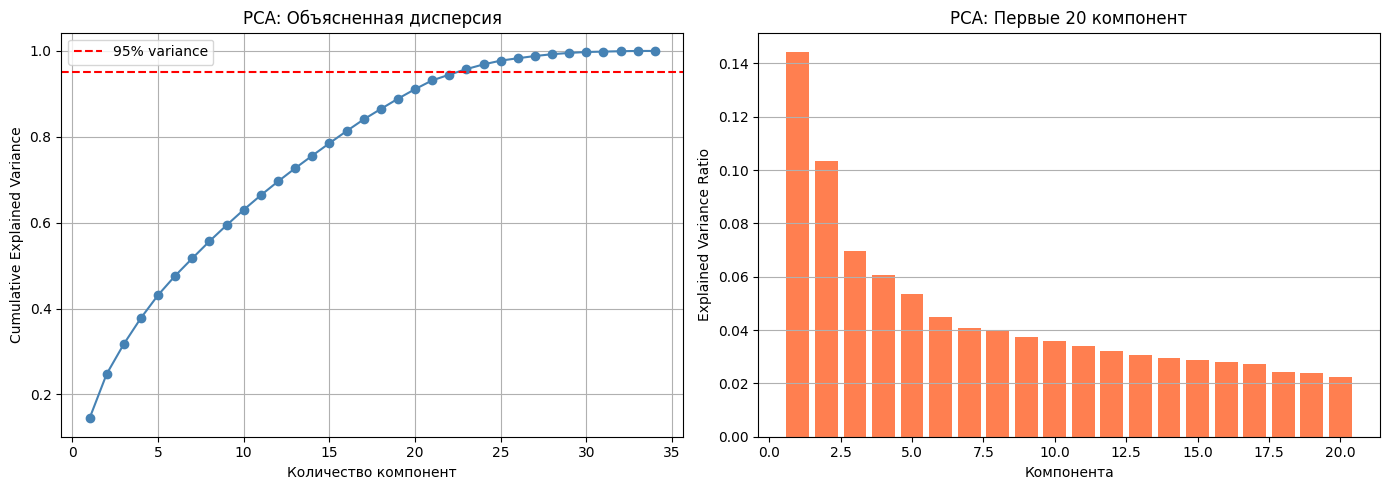

Для 95% дисперсии нужно: 23 компонент (было 34)


In [ ]:
# Определяем количество компонент
pca_full = PCA(n_components=min(X_train_scaled.shape[0], X_train_scaled.shape[1]))
pca_full.fit(X_train_scaled)

cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)

# График
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, len(cumsum_variance) + 1), cumsum_variance, marker='o', color='steelblue')
axes[0].axhline(y=0.95, color='r', linestyle='--', label='95% variance')
axes[0].set_xlabel('Количество компонент')
axes[0].set_ylabel('Cumulative Explained Variance')
axes[0].set_title('PCA: Объясненная дисперсия')
axes[0].legend()
axes[0].grid(True)

axes[1].bar(range(1, 21), pca_full.explained_variance_ratio_[:20], color='coral')
axes[1].set_xlabel('Компонента')
axes[1].set_ylabel('Explained Variance Ratio')
axes[1].set_title('PCA: Первые 20 компонент')
axes[1].grid(True, axis='y')

plt.tight_layout()
plt.show()

n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
print(f"Для 95% дисперсии нужно: {n_components_95} компонент (было {X_train_scaled.shape[1]})")

In [33]:
# Применяем PCA
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
test_pca = pca.transform(test_scaled)

print(f"После PCA: {X_train_pca.shape[1]} признаков")
print(f"Variance explained: {pca.explained_variance_ratio_.sum():.4f}")

После PCA: 23 признаков
Variance explained: 0.9577


## Обучение моделей

In [ ]:
# Random Forest
print("Random Forest")

rf_original = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_original.fit(X_train_scaled, y_train)
y_pred_rf_original = rf_original.predict(X_val_scaled)
acc_rf_original = accuracy_score(y_val, y_pred_rf_original)

print("Исходные признаки:")
print(f"Accuracy: {acc_rf_original:.4f}")
print(classification_report(y_val, y_pred_rf_original))

rf_pca = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_pca.fit(X_train_pca, y_train)
y_pred_rf_pca = rf_pca.predict(X_val_pca)
acc_rf_pca = accuracy_score(y_val, y_pred_rf_pca)

print("\nПосле PCA:")
print(f"Accuracy: {acc_rf_pca:.4f}")
print(classification_report(y_val, y_pred_rf_pca))

Random Forest
----------------------------------------
Исходные признаки:
Accuracy: 0.8091
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       863
           1       0.83      0.78      0.80       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739


После PCA:
Accuracy: 0.7884
              precision    recall  f1-score   support

           0       0.77      0.82      0.79       863
           1       0.81      0.76      0.78       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [36]:
# Logistic Regression
print("Logistic Regression")
print("-" * 40)

lr_original = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_original.fit(X_train_scaled, y_train)
y_pred_lr_original = lr_original.predict(X_val_scaled)
acc_lr_original = accuracy_score(y_val, y_pred_lr_original)

print("Исходные признаки:")
print(f"Accuracy: {acc_lr_original:.4f}")
print(classification_report(y_val, y_pred_lr_original))

lr_pca = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
lr_pca.fit(X_train_pca, y_train)
y_pred_lr_pca = lr_pca.predict(X_val_pca)
acc_lr_pca = accuracy_score(y_val, y_pred_lr_pca)

print("\nПосле PCA:")
print(f"Accuracy: {acc_lr_pca:.4f}")
print(classification_report(y_val, y_pred_lr_pca))

Logistic Regression
----------------------------------------
Исходные признаки:
Accuracy: 0.7913
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       863
           1       0.79      0.80      0.79       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739


После PCA:
Accuracy: 0.7918
              precision    recall  f1-score   support

           0       0.80      0.78      0.79       863
           1       0.79      0.80      0.80       876

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [37]:
# Gradient Boosting
print("Gradient Boosting")
print("-" * 40)

gb_original = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_original.fit(X_train_scaled, y_train)
y_pred_gb_original = gb_original.predict(X_val_scaled)
acc_gb_original = accuracy_score(y_val, y_pred_gb_original)

print("Исходные признаки:")
print(f"Accuracy: {acc_gb_original:.4f}")
print(classification_report(y_val, y_pred_gb_original))

gb_pca = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_pca.fit(X_train_pca, y_train)
y_pred_gb_pca = gb_pca.predict(X_val_pca)
acc_gb_pca = accuracy_score(y_val, y_pred_gb_pca)

print("\nПосле PCA:")
print(f"Accuracy: {acc_gb_pca:.4f}")
print(classification_report(y_val, y_pred_gb_pca))

Gradient Boosting
----------------------------------------
Исходные признаки:
Accuracy: 0.7987
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       863
           1       0.79      0.82      0.80       876

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739


После PCA:
Accuracy: 0.7832
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       863
           1       0.78      0.79      0.78       876

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739



## Сравнение результатов

In [38]:
# Таблица с результатами
results = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Gradient Boosting'],
    'Accuracy (Original)': [acc_rf_original, acc_lr_original, acc_gb_original],
    'Accuracy (PCA)': [acc_rf_pca, acc_lr_pca, acc_gb_pca]
})

results['Difference'] = results['Accuracy (PCA)'] - results['Accuracy (Original)']
print(results)
print(f"\nЛучшая модель: {results.loc[results['Accuracy (Original)'].idxmax(), 'Model']}")

                 Model  Accuracy (Original)  Accuracy (PCA)  Difference
0        Random Forest             0.809086        0.788384   -0.020702
1  Logistic Regression             0.791259        0.791834    0.000575
2    Gradient Boosting             0.798735        0.783209   -0.015526

Лучшая модель: Random Forest


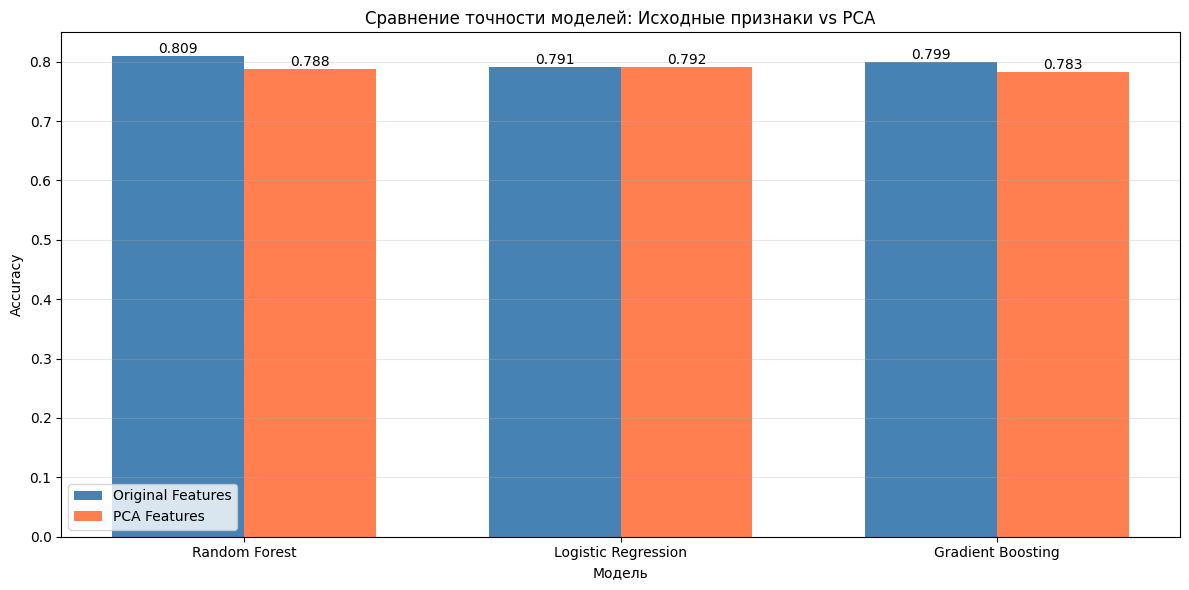

In [39]:
# График сравнения
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

ax.bar(x - width/2, results['Accuracy (Original)'], width, label='Original Features', color='steelblue')
ax.bar(x + width/2, results['Accuracy (PCA)'], width, label='PCA Features', color='coral')

ax.set_xlabel('Модель')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение точности моделей: Исходные признаки vs PCA')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bars in [ax.patches[:3], ax.patches[3:]]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Feature Importance

Top 15 признаков:

          Feature  Importance
13  TotalSpending    0.084984
8         GroupId    0.083144
12       CabinNum    0.082024
1             Age    0.064330
6             Spa    0.062016
4       FoodCourt    0.056764
16     NoSpending    0.055518
0       CryoSleep    0.051538
7          VRDeck    0.050522
17     FamilySize    0.048155
14    NumServices    0.047554
3     RoomService    0.045393
5    ShoppingMall    0.044461
15    AvgSpending    0.039511
10      GroupSize    0.020903


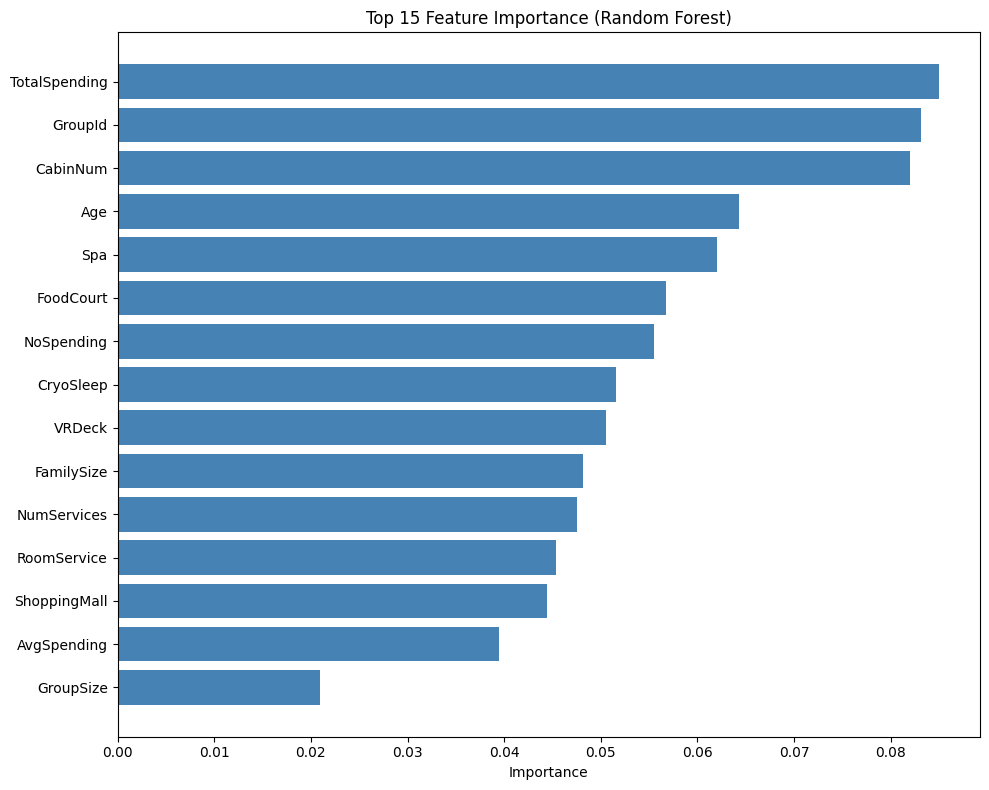

In [40]:
# Важность признаков для Random Forest
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_original.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 15 признаков:\n")
print(feature_importance.head(15))

plt.figure(figsize=(10, 8))
top15 = feature_importance.head(15)
plt.barh(top15['Feature'], top15['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 15 Feature Importance (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

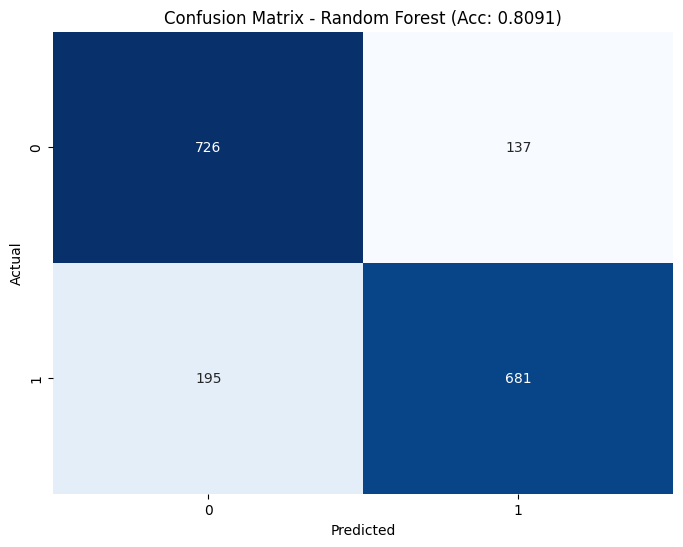

In [41]:
# Confusion matrix для лучшей модели
cm = confusion_matrix(y_val, y_pred_rf_original)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - Random Forest (Acc: {acc_rf_original:.4f})')
plt.show()

## Выводы

**Результаты:**
- Лучшая модель: Random Forest с accuracy 80.9% на исходных признаках
- PCA сократила размерность с 34 до 23 признаков при сохранении 95.77% дисперсии
- Tree-based модели (RF, GB) немного теряют в качестве после PCA (около 2%)
- Logistic Regression практически не теряет качество после PCA

**Важные признаки:**
- TotalSpending, GroupId, CabinNum - топ-3 по важности
- Созданные агрегированные признаки оказались очень полезными
- Траты на сервисы и групповые характеристики критичны для предсказания

**PCA:**
- Полезна для уменьшения размерности и ускорения обучения
- Для линейных моделей работает хорошо
- Для tree-based моделей лучше использовать исходные признаки